## Classification Experiment 1:  
**Engineered features with uniform sampled data**

**UPDATE**: Use **relative** hit positions ONLY for feature engineering and modeling.

This notebook is to preliminarily experiment on various classification models to distinguish pion and muon by using **engineered features** from the hit dataset and existing features (`momentum`) from the event dataset. These engineered features have been explored in the recent regression experiments to fit the ring_radius from a variable number of hits attached to each event. Considering the ring_radius is one of the key features to classify pion and muon, the hypothesis was we could expect a positive classification performance when adopting these engineered features.

**IMPORTANT ASSUMPTIONS/CONDITIONS**:   
(1) The `label` column from the event dataset has been taken as the ground truth for the classification task in the notebook. 1 for muon; 0 for pion.   

(2) Data used for the classification task have been randomly sampled as the same number of examples(events) in each bin of track_momentum with bin size = 1 Gev;  
Filter and keep the data within the momentum range 20 - 45 GeV;   
Filter and keep hits with CHOD delta <= 0.5 (in-time hits only).   
Note that in the current regression approach we only sampled muon events, but for the classification problem in this notebook we have both muon and pion.

Any features produced from the SOTA (current NA62 algorithm) are not included in the classification task. 

In [1]:
import h5py 
import numpy as np 
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import glob
import warnings

### 1.0 Read hit data

In [4]:
# read hit data with relative position from a local sampled dataset
grouped_hit_data = pd.read_csv('../../../data_0/grouped_hit_data_relative.csv')

In [5]:
# convert label to int datatype
grouped_hit_data['label'] = grouped_hit_data['label'].astype('int')
grouped_hit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900602 entries, 0 to 900601
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          900602 non-null  int64  
 1   event               900602 non-null  int64  
 2   x_realigned_min     900602 non-null  float64
 3   x_realigned_max     900602 non-null  float64
 4   x_realigned_median  900602 non-null  float64
 5   y_realigned_min     900602 non-null  float64
 6   y_realigned_max     900602 non-null  float64
 7   y_realigned_median  900602 non-null  float64
 8   min_hit_radius      900602 non-null  float64
 9   max_hit_radius      900602 non-null  float64
 10  mean_hit_radius     900602 non-null  float64
 11  median_hit_radius   900602 non-null  float64
 12  rms_hit_radius      900602 non-null  float64
 13  momentum            900602 non-null  float64
 14  label               900602 non-null  int64  
 15  x_min_sum           900602 non-nul

### 2.0 Perform model training

In [4]:
# import ML models and tools
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from helpers import mean_std_cross_val_scores

#### 2.1 Prepare train/test df

In [5]:
# split to train and test dataframe
train_df, test_df = train_test_split(grouped_hit_data,
                                     test_size=0.25,
                                     random_state=42,
                                     shuffle=True
                                    )

In [6]:
# check numbers of muon and pion in training df (0 for muon; 1 for pion)
train_df['label'].value_counts()

0    597044
1     78407
Name: label, dtype: int64

In [7]:
# check numbers of muon and pion in testing df
test_df['label'].value_counts()

0    198648
1     26503
Name: label, dtype: int64

In [8]:
# generate X and y for training and test df
X_train, y_train = train_df.drop(columns=["Unnamed: 0",
                                          "event",
                                          "label"]), train_df["label"]
X_test, y_test = test_df.drop(columns=["Unnamed: 0",
                                       "event", 
                                       "label""]), test_df["label"]

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 675451 entries, 137745 to 121958
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   x_realigned_min     675451 non-null  float64
 1   x_realigned_max     675451 non-null  float64
 2   x_realigned_median  675451 non-null  float64
 3   y_realigned_min     675451 non-null  float64
 4   y_realigned_max     675451 non-null  float64
 5   y_realigned_median  675451 non-null  float64
 6   min_hit_radius      675451 non-null  float64
 7   max_hit_radius      675451 non-null  float64
 8   mean_hit_radius     675451 non-null  float64
 9   median_hit_radius   675451 non-null  float64
 10  rms_hit_radius      675451 non-null  float64
 11  momentum            675451 non-null  float64
 12  track_pos_x         675451 non-null  float64
 13  track_pos_y         675451 non-null  float64
 14  x_min_sum           675451 non-null  float64
 15  y_min_sum           675451 no

#### 2.2 Define pipelines and metrics

In [10]:
classification_metrics = ["accuracy", "precision", "recall", "f1"]

In [11]:
# define pipelines

preprocessor = StandardScaler()

pipe_dummy = make_pipeline(
    preprocessor, DummyClassifier())

pipe_lr = make_pipeline(
    preprocessor, LogisticRegression(max_iter=2000, 
                                     random_state=123,
                                     class_weight="balanced"))

pipe_dt = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=123,
                                                             class_weight="balanced"))

pipe_rf = make_pipeline(
    preprocessor, RandomForestClassifier(random_state=123, class_weight="balanced"))

pipe_xgb = make_pipeline(
    preprocessor, XGBClassifier(random_state=123, verbosity=0))

pipe_lgbm = make_pipeline(
    preprocessor, LGBMClassifier(random_state=123))

pipe_catboost = make_pipeline(
    preprocessor, CatBoostClassifier(verbose=0, random_state=123))

pipe_sklearn_histGB = make_pipeline(
    preprocessor, HistGradientBoostingClassifier(random_state=123))

pipe_sklearn_GB = make_pipeline(
    preprocessor, GradientBoostingClassifier(random_state=123))

classifiers = {
    "dummy classifier": pipe_dummy,
    "logistic regression": pipe_lr,
    "decision tree": pipe_dt,
    "random forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catboost,
    "sklearn_histGB": pipe_sklearn_histGB,
    "sklearn_GB": pipe_sklearn_GB,
}

In [12]:
warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

#### 2.3 Train models and obtain cross validation results

In [13]:
%%time
results = {}

for (name, model) in classifiers.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=classification_metrics
    )

CPU times: user 54min 42s, sys: 1min 5s, total: 55min 48s
Wall time: 36min 35s


In [14]:
pd.DataFrame(results).T

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
dummy classifier,0.098 (+/- 0.014),0.071 (+/- 0.003),0.884 (+/- 0.000),0.884 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)
logistic regression,1.221 (+/- 0.065),0.077 (+/- 0.003),0.855 (+/- 0.001),0.855 (+/- 0.000),0.436 (+/- 0.002),0.436 (+/- 0.001),0.842 (+/- 0.002),0.842 (+/- 0.000),0.575 (+/- 0.002),0.575 (+/- 0.001)
decision tree,12.135 (+/- 0.207),0.084 (+/- 0.002),0.980 (+/- 0.001),1.000 (+/- 0.000),0.921 (+/- 0.003),1.000 (+/- 0.000),0.908 (+/- 0.003),1.000 (+/- 0.000),0.915 (+/- 0.002),1.000 (+/- 0.000)
random forest,141.802 (+/- 0.519),1.562 (+/- 0.005),0.976 (+/- 0.000),1.000 (+/- 0.000),0.967 (+/- 0.001),1.000 (+/- 0.000),0.825 (+/- 0.002),1.000 (+/- 0.000),0.891 (+/- 0.001),1.000 (+/- 0.000)
XGBoost,19.040 (+/- 0.700),0.123 (+/- 0.008),0.999 (+/- 0.000),0.999 (+/- 0.000),0.996 (+/- 0.000),0.999 (+/- 0.000),0.991 (+/- 0.001),0.996 (+/- 0.000),0.994 (+/- 0.000),0.998 (+/- 0.000)
LightGBM,1.411 (+/- 0.010),0.227 (+/- 0.004),0.991 (+/- 0.000),0.991 (+/- 0.000),0.976 (+/- 0.002),0.979 (+/- 0.001),0.942 (+/- 0.002),0.947 (+/- 0.001),0.959 (+/- 0.002),0.963 (+/- 0.001)
CatBoost,24.581 (+/- 0.536),0.136 (+/- 0.002),1.000 (+/- 0.000),1.000 (+/- 0.000),0.999 (+/- 0.000),1.000 (+/- 0.000),0.997 (+/- 0.000),0.999 (+/- 0.000),0.998 (+/- 0.000),1.000 (+/- 0.000)
sklearn_histGB,3.524 (+/- 0.054),0.216 (+/- 0.008),0.990 (+/- 0.000),0.991 (+/- 0.000),0.976 (+/- 0.002),0.979 (+/- 0.000),0.941 (+/- 0.002),0.947 (+/- 0.000),0.958 (+/- 0.001),0.963 (+/- 0.000)
sklearn_GB,221.796 (+/- 43.069),0.223 (+/- 0.010),0.955 (+/- 0.001),0.955 (+/- 0.000),0.912 (+/- 0.002),0.915 (+/- 0.001),0.676 (+/- 0.004),0.679 (+/- 0.001),0.777 (+/- 0.003),0.779 (+/- 0.001)


#### 2.4 Performance of best model (CatBoostClassifier) on test data

In [15]:
pipe_catboost.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x137075150>)])

In [16]:
# prediction accuracy on test data
pipe_catboost.score(X_test, y_test)

0.9995469706996638

In [17]:
# prediction recall on test data
recall_score(y_test, pipe_catboost.predict(X_test))

0.9975474474587782

In [18]:
# output predicted label vs given label (assuming as ground truth)
y_pred = pipe_catboost.predict(X_test)

pred_df = pd.DataFrame(y_pred, y_test).reset_index()
pred_df.columns=['given_label','predited_label']

In [19]:
pred_df

,predited_label,given_label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
225146,0,0
225147,0,0
225148,0,0
225149,1,1


**Manually calculate pion efficiency on test data:**

In [20]:
# total number of true pion
num_pi_true = len(pred_df.query('given_label == 1'))
# Ture Positive (correctly predicted as pion)
num_pi_TP = len(pred_df.query('given_label == 1 & predited_label == 1'))

# recall(True Positive Rate)/pion efficiency
pi_efficiency = num_pi_TP/num_pi_true
pi_efficiency

0.9986024551463645

**Manually calculate muon efficiency on test data:**

In [21]:
# total number of true muon
num_mu_true = len(pred_df.query('given_label == 0'))
# False Positive (incorrectly predicted as pion)
num_mu_FP = len(pred_df.query('given_label == 0 & predited_label == 1'))

# False Positive Rate/muon efficiency
mu_efficiency = num_mu_FP/num_mu_true
mu_efficiency

0.0003271658378465441

**show confusion matrix**

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = ConfusionMatrixDisplay.from_estimator(
    pipe_catboost, X_test, y_test, values_format="d", display_labels=["muon", "pion"]
)
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()
print(cm.confusion_matrix)

#### 2.5 ROC curves for three classifiers

For a quick comparison purpose, the ROC curve will be plotted for three classifiers from the above selection. 

In [22]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

In [23]:
# fit logisticregression on training data
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=2000,
                                    random_state=123))])

In [24]:
# fit randomforestclassifier on training data
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=123))])

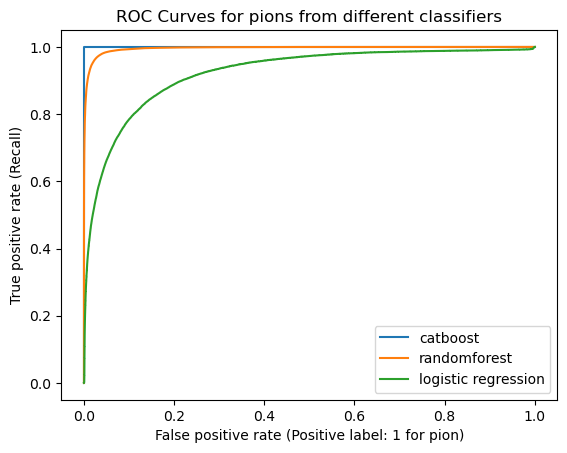

In [25]:
# plot ROC curves for three classifiers
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, pipe_lr.predict_proba(X_test)[:, 1])
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, pipe_rf.predict_proba(X_test)[:, 1])
fpr_cb, tpr_cb, thresholds_cb = roc_curve(y_test, pipe_catboost.predict_proba(X_test)[:, 1])

plt.plot(fpr_cb, tpr_cb, label="catboost")
plt.plot(fpr_rf, tpr_rf, label="randomforest")
plt.plot(fpr_lr, tpr_lr, label="logistic regression")

plt.xlabel("False positive rate (Positive label: 1 for pion)")
plt.ylabel("True positive rate (Recall)")
plt.legend(loc="best")
plt.title("ROC Curves for pions from different classifiers");

**More works to be performed**:  

(1) Model interpretation and feature importance analysis.   
(2) Experiment the modeling approach on other randomly sampled data.

### APPENDIX

The follow two appendixes are for the reference how the `grouped_hit_data` used in the notebook was sampled and processed from the raw data 'CaloRICH_Run11100_CTRL_v1.h5'.  

**Appendix A** - Read raw data, uniform sample, and create df_hit_data   

**Appendix B** - Feature engineering

**A few preliminary experiments as below**:

**Catboost deal with imbalanced data**

In [ ]:
y_train.value_counts()

In [ ]:
597044/78407

In [ ]:
# set scale_pos_weight to deal with class imbalance
# reference: https://www.kaggle.com/code/kaanboke/xgboost-lightgbm-catboost-imbalanced-data
pipe_catboost_balanced = make_pipeline(
    preprocessor, CatBoostClassifier(verbose=0, 
                                     random_state=123,
                                     scale_pos_weight=7))

In [ ]:
%%time
result_cat_balanced = mean_std_cross_val_scores(
    pipe_catboost_balanced, X_train, y_train, return_train_score=True, scoring=classification_metrics
)

pd.DataFrame(result_cat_balanced).T

In [ ]:
pipe_catboost_balanced.fit(X_train, y_train)

In [ ]:
# prediction recall on test data
recall_score(y_test, pipe_catboost_balanced.predict(X_test))

In [ ]:
pipe_catboost_balanced.score(X_test, y_test)

In [ ]:
# output predicted label vs given label (assuming as ground truth)
y_pred = pipe_catboost_balanced.predict(X_test)

pred_df = pd.DataFrame(y_pred, y_test).reset_index()
pred_df.columns=['given_label','predited_label']

In [ ]:
# total number of true muon
num_mu_true = len(pred_df.query('given_label == 0'))
# False Positive (incorrectly predicted as pion)
num_mu_FP = len(pred_df.query('given_label == 0 & predited_label == 1'))

# False Positive Rate/muon efficiency
mu_efficiency = num_mu_FP/num_mu_true
mu_efficiency

In [ ]:
# plot ROC curves for three classifiers
fpr_cb, tpr_cb, thresholds_cb = roc_curve(y_test, pipe_catboost_balanced.predict_proba(X_test)[:, 1])

plt.plot(fpr_cb, tpr_cb, label="catboost_balanced")
plt.plot(fpr_rf, tpr_rf, label="randomforest")
plt.plot(fpr_lr, tpr_lr, label="logistic regression")

plt.xlabel("False positive rate (Positive label: 1 for pion)")
plt.ylabel("True positive rate (Recall)")
plt.legend(loc="best")
plt.title("ROC Curves for pions from different classifiers");